ATIS Flight Reservations - Information Extraction

ATIS Flight Reservations - Information Extraction
 
Table of Contents:
 
1. Understanding the Data
2. Information Extraction
    . Pipeline for Information Extraction Systems
    . Named Entity Recognition (NER)
3. Models for Entity Recognition
    . Rule-based models
    · Regular Expression Based Rules (ex)
    · Chunking
    . Probabilistic models
    · Unigram and Bigram models
Naive Bayes Classifier
Conditional Random Fields (CRFs)
The ATIS (Airline Travel Information Systems) dataset consists of English language queries for booking (or requesting
information about) flights in the US.
 
Each word in a query (i.e. a request by a user) is labelled according to its entity-type, for e.g. in the query 'please show
morning flights from chicago to new york', 'chicago' and 'new york are labelled as 'source' and 'destination' locations
respectively while 'morning' is labelled as 'time-of-day' (the exact labelling scheme is a bit different, more on that later).
 
Some example queries taken from the dataset are shown below:
 
{
'what flights leave atlanta at about DIGIT in the afternoon and arrive in san francisc
 
'what is the abbreviation for canadian airlines international',
"i 'd like to know the earliest flight from boston to atlanta",
'show me the us air flights from atlanta to boston',
'show me the cheapest round trips from dallas to baltimore',
"i 'd like to see all flights from denver to philadelphia"
}

**Objective**
Our objective is to build an information extraction system which can extract entities relevant for booking flights (such as
source and destination cities, time, date, budget constraints etc.) in a structured format from a given user-generated query.

A structured format could be a dictionary, a JSON, etc. - basically anything that can be parsed and used for looking up
relevant flights from a database.

**Downloads**

The dataset is divided into five folds, each fold having a training, validation and test set. You can download the dataset here:
http://lisaweb.iro.umontreal.ca/transfert/lisa/users/mesnilgr/atis/

**Understanding the Data**

Let's understand the structure of the training data. The dataset is provided in five folds, each fold having a training,
validation, test set and a dict (explained later). All folds are structurally identical, so understanding one fold is enough to
understand the entire set.

In [ ]:
# import libaries
import numpy as np
import pandas as pd
import nltk, pprint
import matplotlib.pyplot as plt
import random

import gzip, os, pickle # gzip for reading the gz files, pickle to save/dump trained model
import pickle as cPickle

import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# supress warnings
import warnings
warnings.filterwarnings ('ignore')

Let's now read the first fold of the dataset. The data is in .gz files, so we'll need the gzip library as well.


In [ ]:
# read the first part of the dataset
# each part (.gz file) contains train, validation and test sets, plus a dict

filename = 'atis.fold0.pkl.gz'
f = gzip.open(filename, 'rb')
try:
   train_set, valid_set, test_set, dicts = pickle.load(f, encoding='latin1')
except:
    train_set, valid_set, test_set, dicts = pickle.load(f)
finally:
  
    
f.close()

In [ ]:
# type  and size of the train set

print(type(train_set))
print()

# type of the three element in the tuple

print(type(train_set[0]), (type(train_set[1]), (type(train_set[2]))
print(len(train_set[0]), (len(train_set[1]), (len(train_set[2]))

The training set is a tuple containing three lists of same lengths as shown above. Similarly, the validation and test sets
contain three lists as well (shown below).

In [ ]:
# Validation set
print(type(valid_set[0]), (type(valid_set[1]), (type(valid_set[2]))
print(len(valid_set[0]), (len(valid_set[1]), (len(valid_set[2]))
print()

#test set
print(type(test_set[0]), (type(test_set[1]), (type(test_set[2]))
print(len(test_set[0]), (len(test_set[1]), (len(test_set[2]))

Thus, we have the train, validation and test sets each containing three lists of different lengths. Now, let's understand the
data stored in the three lists.

In [ ]:
# first few elements in each list of the training set
pprint.pprint(train_set[0][:3]) # encode with words like which , flight
print('#'*50)
pprint.pprint(train_set[1][:3]) # Ignore
print('#'*50)
pprint.pprint(train_set[2][:3])  # IOB Inside outside beginning text Label
print('#'*50)

In [ ]:
#storing the three elements of the tuple in three objects
# The '_' is a conventional variable in python used to store non-useful/dummy objects
train_x, _, train_label = train_set
val_x, _, val_label = valid_set
test_x, _, test_label = test_set

So now, for training, validation and test sets, we have the **encoded words and labels** stored in the lists (train_x, train_label),
(val_x, val_label) and (test_x, test_label). The first list represents the actual words (encoded), and the other list contains their
labels (again, encoded).

Let's now understand the structure of the lists.

In [ ]:
# each list in the tuple is a numpy array (which us a complete sentence/query)
# printing first list in the tuple's first element
# each element represents a word of the query
# this translates to 'what flights leave atlanta
train_x[0]

In [ ]:
# labels are stored in the third list train _label
train_label [0]

To map the integers to words, we need to use the dictionaries provided. The dicts <code>words2idx</code> and <code>labels2idx </code> map the numeric ids to the actual words and labels respectively.

In [ ]:
# dict to map numbers to words/labels
print(type(dicts))
print(dicts.keys())

In [ ]:
# each key:value pair is itself a dict
print(type(dicts['lbels2idx']))
print(type(dicts['tabels2idx']))
print(type(dicts['words2idx']))

In [ ]:
# Storing labels and words in separate variables
# we'll need only two of these dicts - words and labels
words =dicts['words2idx']
labels =dicts['labels2idx']
tabels=dicts['tables2idx']

In [ ]:
# each key of 'words' is a word, each value its index
#printing some random key:value pairs of 'words'
random.sample(words.items(), 10)

In [ ]:
# Now we map numeric value v in as sentence with the k, v in the dict
#train_x contains the list of training queries; train_x[0] is the first query
#this is the first query
[k for val in train_x[0] for k,v in words.items() if v==val]

In [ ]:
# let's look at the first few queries
sents=[]
for i in range(30):
    sents.append(" ".join ([k for val in train_x[0] for k,v in words.items() if v==val]))
sents

Similarly we map the encoded values of each words's label using the <code> labels </code> dict.

In [ ]:
# Labels dict contains IOB(Inside-outside-beginning) labelled entities
#printing some randoms k:v pairs
random.sample(labels.items(),25)

### Reversing The dictionaries

since the dict <code> words </code> and <code> labels </code> are key:value pairs of index: word/labels, let's reverse the dicts so that we don't have to do a reverse lookup everytime

In [ ]:
# converting words_to_id to id_to_words
# and labels_to_id to id_to_labels
id_to_words = {words[k]:k for k in words}
id_to_labels = {labels[k]:k for k in labels}

Now we can print the words and corresponding labels simply by looking up the value of a numeric index of each word. Let's write a function which takes in an index and returns the corresponding query with its labels.

In [ ]:
# takes in an integer index corresponding to a query
# and returns a list of (word, label) pairs
def print_query(index):
    w = [id_to_words[id] for id in train_x[index]]
    1 =[id_to_labels[id] for id in train_label[index] ]
    return list(zip(w, 1))

In [ ]:
# sample query
print_query(3900)

Also, some queries specify stopver cities, such as this

In [ ]:
#example query: stopover city
print_query(3443)

### Information Extraction
Information Extraction (IE) refers to the task of extracting structured information from unstructured text data. In this case,we want to extract all pieces of information from a query which are useful in making a flight reservation, such as source and destination cities, date of travel, price range etc.
    
Other examples of IE tasks are extracting information about stock market announcements from financial news (which could be useful for predicting stock prices etc.), extracting structured information from large corpora of documents such as
encyclopedias, government documents etc. On wikipedia, for e.g., some structured information is shown on the right side of the pages:

Most IE tasks start with the task of Named Entity Recognition (NER) - identifying mentions of entities in the text. Loosely
speaking, entities refer to names of people, organizations (e.g. Air India, United Airlines), places/cities (Mumbai, Chicago),
dates and timepoints (May, Wednesday, morning flight), numbers of specific types (e.g. money - 5000 INR) etc.

The general process of information extraction is described below.

### Information Extraction Pipeline
Most IE pipelines start with the usual text preprocessing steps - sentence segmentation, word tokenisation and POS tagging. After preprocessing, the usual tasks are named entity recognition, and optionally relation recognition.

Note that this is a generic pipeline, and you may make modifications according to the nature of your application. For example, you may add a 'spell check/correction layer' as the first preprocessing step if you expect some input data to have
spelling errors.

A generic IE pipeline schema, taken from the official NLTK book, is show below

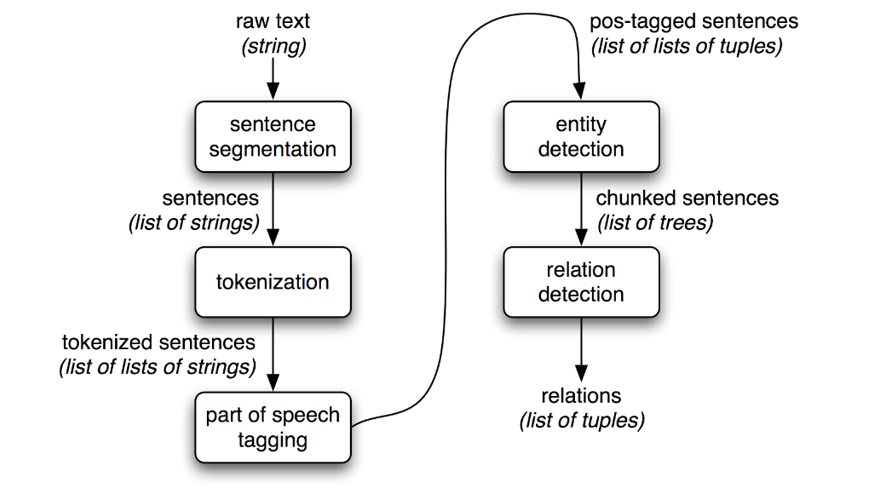

### Preprocessing
The usual preprocessing steps are - if the raw input data is in the form of paragraphs, it is converted into sentences using a **sentence segmenter**, then broken down into tokens using **tokenisation**, and finally each token is **POS tagged**.

#### Named Entity Recognition (NER)
The labels corresponding to each word/token, as shown above, are of three types - I, O and B, which stand for inside, out
and beginning (called **IOB tags**). This is a common way of labelling text data meant for NER tasks. The task of information
extraction and named-entity recognition is explained in detail below. First, let's understand the task of NER and IOB labelling
in detail.

Some example IOB tagged words are shown below:



In [ ]:
# run multiple times to see samples
# randomly chosen sample IOB-tagged queries from training data
i=random.randrange(len(train_x))
print_query(i)

IN the query name above, there are two named entities (cities)- san francisco and denver.

since san francico comprises of two words, the first one is tagged B and the second words tagged as /- On the other hand dever is only one word, so there's no /- tag. All the words are not entities are thus marked O (outside any entity)


The **NER task** is to ** Predict the IOB labels ** of each words.

### NER as a sequence-Labelling Task

The task of **training an NER system**, i.e. assigning an IOB label to each word, is a **sequence labelling task** similar to POS tagging. For sequence labelling, one can try rule-based models such as writing **regular-expression based rules** to extract
entities, **chunking** patterns of POS tags into an 'entity chunk' etc. (we'll try some of these below)

One the other hand, one can use **probabilistic sequence labelling models** such as **HMMs, the Naive Bayes** classifier (classifying each word into one label class), **Conditional Random Fields (CRFs)** etc.

Once the IOB tags of each word are predicted, we can **evaluate the model** using the usual metrics for multi-class classification models (num_classes = number of IOB tags).

### Model for Entity Recognition
In the following sections, we'll build a variety of models for entity recognition, i.e. to predict the sequence of IOB tag of
words. We'll try the two broad approaches - **rule-based models** and **probabilistic models**.

Before that, we need to do some basic preprocessing of the data.

### Part of Speech Tagging
The usual preprocessing steps are sentence segmentation, tokenisation and POS tagging, but since in this case the raw data is already split into sentences (queries) and words, we only need to do POS tagging.

The function below takes in a list of (encoded) sentences, uses the dict <code> id_to_words </code> to decode the numeric to the
corresponding word, and returns the POS tagged list of sentences.


In [ ]:
# POS tagging sentences
# takes in a list of sentences and returns a list of POS-tagged sentences
# in the form(word,tag)

def pos_tag(sent_list):
    pos_tag=[]
    tagged_words=nltk.pos_tag([id_to_words[val]for val in sent])
    pos_tag.append(tahhed_words)
    return pos_tags

In [ ]:
# Pos Tagging train, validation and test data
train_pos =pos_tags(train_x)
valid_pos =pos_tags(val_x)
test_pos =pos_tags(test_x)

In [ ]:
# looking at tags of some randomly chosen queries
#notice that most cities after "To" are incorrectly tagged as VB
i = random.randrange(len(train_pos)
train_pos[i]                   
                                      

## Problems with the NLTK Tagger

Note that almost all city/airport names that come after 'to/TO' are tagges as verbs 'VB', which is clearly incorrect. This is because NLTK's built-in tagger is trained using the penntreebank dataset, and it takes 'to/TO' as a strong signal for a 'VB'.

In general, the performance of a POS tagger depends a lot on the data used to train it. There are alternatives to it - one, you can try using an alternative tagger such as the Stanford tagger, Spacy etc. (though note that getting them up and running in
python may take a bit of time in installing dependencies/debugging etc.).

The other alternative (recommended as a quick fix) is to use a **backup tagger**(Backoff option will allow you to change multiple tagger together if one tagger doesn't know how to tag a word it can backoff to another words) within NLTK, i.e. manually specify a unigram/bigram tagger to be used, and backed up by the standard NLTK tagger. 

Creating 3-tuple of <code> **(word, pos, IOS_labels)** </code>
To train a model, we need the entity labels of each word along with the POS tags, for e.g. in this format
                            ('show', 'VB', '0'),
                            ('me', 'PRP', 'O'),
                            ('the', 'DT', 'O'),
                            ('cheapest', 'JJS', 'B-cost_relative'),
                            ('round', 'NN', 'B-round_trip'),
                            ('trips', 'NNS', 'I-round_trip'),
                            ('from', 'IN', 'O'),
                            ('dallas', 'NN', 'B-fromloc.city_name'),
                            ('to', 'TO', '0'),
                            ('baltimore', 'VB', 'B-toloc.city_name')

Let's convert the training validation and test sentences to this form. Since we have already done POS tagging of the queries, we'll write a function which takes queries in the form(word_pos_tag) and labels as input, and return the list of sentence in the form (word, pos_tag, iob_labels).




In [ ]:
# Function to create (word, pos_tag, iob_lables) tuple for a given datatset

def create_word_pos_label(pos_tagged_data, labels):
    iob_lables=[]                  # initialize the list of 3-tuples to be returned

    for sent in list(zip(pos_tagged_data, labels)):
        pos=sent[0]
        labels=sent[1]
        zipped_list=list(zip(pos, labels))   # [(word, pos), label]


      #create (word, pos, label) tuple from zipped list
        tuple_3 = [(word_pos_tuple[0], word_pos_tuple[1], id_to_labels[labels])
                  for word_pos_tuple, label in zipped_list]
        iob_labels.append(tuple_3)
        return iob_labels

In [ ]:
# printing some sample queries in the form (word, pos, label)
train_labels =  create_word_pos_label(train_pos, train_label)
train_label[4:6]

In [ ]:
# storing validation and test data as well as (word, pos, label)
valid_labels = create_word_pos_label(valid_pos, val_label)
test_labels = create_word_pos_label(test_pos, test_label)

Now that we have converted the queries in the form (word, pos, label), we can convert them into a tree format and observe
the actual entities more clearly (rather than IOB labels).

In general, IOB tagged sentences are represented in either of the two common formats - 1. The <code>(word, pos, label)</code> or
the tagged list format or 2. The tree format.

As we will see later, some built-in models/sequence taggers in NLTK need the data in the tree format.

#### Converting List to Tree Format
Let's now convert the sentences into a tree format, which is needed by NLTK to train taggers. In NLTK, there are two main
methods to convert between the two formats (the list of tags and tree) - <code> conlltags2tree</code> and <code>tree2conlltags.</code>

In [ ]:
from nltk.corpus import conll2000
from nltk import conlltags2tree, tree2conlltags

# print a sample tree in tuple format:
train_labels[3]

In [ ]:
# converting the sample sentence above to tree format
tree=conlltags2tree(train_labels[3])
print(tree)

The tree above shows three entities in the query - <code>flight_mod earliest</code> (earliest), <code>fromloc.city_name</code> (boston),
<code>toloc.city_name</code> (atlanta).

Let's now convert all training sentences to trees.

In [ ]:
# converting training, validation and test datasets to tree format
train_trees = [conlltags2tree(sent) for sent in train_labels]
valid_trees = [conlltags2tree(sent) for sent in valid_labels]
test_trees = [conlltags2tree(sent) for sent in test_labels]

In [ ]:
# print some sample training trees
i=random.randrange(len(train_trees))
print(train_trees[i])

Now that we have the queries in free format, we can build some models to extract entities

### Rule-Based Models for Entity Recognition
The most basic rule-based system can be written using regular expressions. The idea is to manually identify patterns which indicate occurence of entities we are interested in, such as source and destination cities, mentions of dates and time, names of organisations (in this case airlines such as united airlines, american airlines etc.) and write regular expressions to match them.

### Chunking
**Chunking is a way to identify meaningful sequences of tokens called chunks in a sentence**. It is commonly used to identify
sequences of nouns, verbs etc. For example, in the example sentence taken from the NLTK book: #https://www.nltk.org/book/ch07.html

S = "We saw the yellow dog"

there are two noun phrase chunks as shown below. Each outer box represents a chunk.

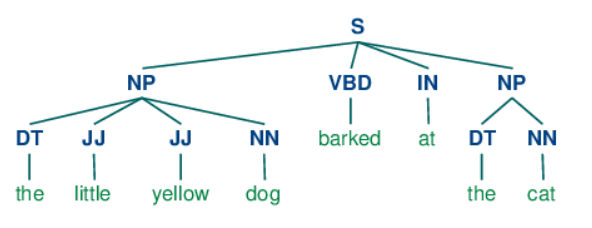

The corresponding **IOB representation** of the same is as follows:

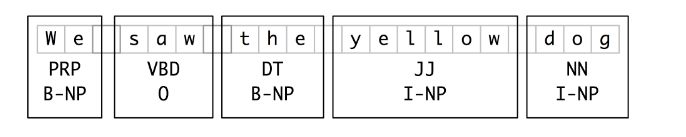

simlilarly, in our dataset, the following sentence contains chunks such as fromloc.city_name (san francisco) class_type (first class), depart_time.time(DIGITDIGIT noon) etc

In [ ]:
# sample chunks
print(train_tree[3468])

There are various techniques for building chunkers, such as regex based, unigram and bigram chunkers etc.

#### Regular Expressions Based Chunkers

Regex based chunkers define what is called a **chunk grammar**. A **chunk grammar is a pattern of POS tags** which are
likely to form a particular chunk (and thus POS tagging is a necessary preprocessing step for such chunkers).

The example from the NLTK book defined a simple garmmar to identify noun phrase chunks:


In [ ]:
# chunking example sentence
sentence = [("the", "DT"), ("little", "JJ"), ("yellow", "JJ"),
("dog", "NN"), ("barked", "VBD"), ("at", "IN"), ("the", "DT"), ("cat", "NN") ]


Now, we **define a chunk grammar** to identify noun phrase chunks as follows: A noun phrase chunk occurs when an
optional determiner (DT) is followed by any number of adjectives (JJ) and then a noun (NN).

In [ ]:
# define chunk grammar to identify noun phrase chunks
# an optional determiner (DT), followed by any number of adjectives (JJ)
# and then a noum (NN)
grammar = "NP_chunk: {<DT> ?< JJ> *< NN>}"


We now use the <code> **nltk.RegexpParser** </code>  to parse the given sentence. The output will be a tree which identifies the NP
chunks.

In [ ]:
# parse the sentence
cp = nltk.RegexpParser(grammar)
result = cp.parse(sentence)
print(result)

The first NP chunks is "the little yellow dog" and second one is that "the cat". One can also print the list representation of this tree as follows:

In [ ]:
# list form of the tree
tree2conlltags(result)

Similarly, we can write rules to identify entities in the airlines dataset. Before building any useful chunkers, let's first make a
**baseline chunker** - one which assigns the label 'O' to every word and see its evaluation metrics. We can then compare the
eventual models with this one.


In [ ]:
# baseline (dummy chunker)
# assigns 'O' to each word

grammar = !!

# initialise cp
cp = nltk.RegexpParser(grammar)

# evaluate results against actual IOB labels
result = cp.evaluate(train_trees)
print(result)

An accuracy of 63.8% shows that about 63% words have the tag 'O', i.e. they do not fall in any chunk/entity. The other metrics are 0 since we did not predict any chunks at all.
Let's now look at a few sentences and try to identify patterns for the chunks <code>fromloc.city_name </code> and <code> toloc.city_name </code> (since these are the most common entities).

In [ ]:
# sample queries
print(train_trees[random.randrange(len(train_trees))])

It is easy to see that a common pattern is from city_1 to city_2. The POS tag of from is 'IN', to is 'TO'. However, there's an interesting flaw in the tagger - most cities (city_2) after TO are tagged as as verb 'VB' (the nltk tagger uses 'TO' as a string signal for a verb


Nevertheless the pattern <code> from/IN city_1/JJ city_1/NN to/TO city_2/VB city_2/NN </code> (you can try looking at multiple sentences and verify

Let's define the grammar to identify the two types of chunks - fromloc.city_name and toloc.city_name . The
syntax is to simply write two regexes within the grammar, one for each, one after the other.

In [ ]:
# grammar for source and destination city chunks
grammar = ''!
fromloc.city_name: {<JJ> ?< NN>}
toloc.city_name: {<VB><NN>?}
...

cp = nltk.RegexpParser (grammar)
result = cp.evaluate(train_trees)
print(result)

The results are although better than the baseline model, they are still quite unimpressive. Notice that now precision, recall
and f-score are non-zero, indicating that the chunker is able to identify at least some chunks correctly (in this case
 <code> fromloc.city_name and toloc.city_name ) </code> .

We can add more regex patterns for other chunk types as well.

We can see that in this dataset, queries are quite complex (large variety of labels, sentence structures etc.) and thus it is
extremely hard write hand-written rules to extract useful entities.

Thus, we need to train probabilistic models such as CRFs, HMMs etc. to tag each word with its corresponding entity label.


### Probabilistic Models for Entity Recognition
Let's experiment with a few different models for labelling words with named entities.
## unigram chunker
Let's now try a unigram chunker. A **unigram chunker** assigns the IOB label that is most likely for each POS tag.

The following code defines a class <code>UnigramChunker </code> which (on initialisation) first converts the tree form of a sentence to
the list form (word, pos, label), extracts the (pos, label) pairs and computes the unigram probabilities <code>P(label | pos)</code> for
each POS tag. It then simply assigns the label that is most likely for the POS tag.

The <code>parse () </code>method of the class takes a sentence in the form (word, pos) as the input, extracts only the pos tag from it,
and uses the unigram tagger to assign the IOB label to each word. It then returns the sentence after converting it to a tree
format.

Note that the unigram tagger, like the previous regex-based chunkers, does not make use of the word itself but only the
word's POS tag.

In [ ]:
#UNIGRAM CHUNKER

from nltk import ChunkParser

class UnigramChunker(ChunkParser):
    def __init__(self, train_sents):
        # convert train sents from tree format to tags
        train_data =[[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)] for sent in train_sents]
        self.tagger-nltk.UnigramTagger(train_data)


     def parse(self, sentence):
         pos_tags =[pos for (word, pos) in sentence]
         tagged_pos = self.tagger.tag(pos_tags)
         chunktags =[chunktag for (pos, chunktag) in tagged_pos_tags]


        #convert to tree again
         conlltags=[(word, pos, chunktag) for ((word, pos), chunktag) in zip(sentence, chunktag]
         return nltk.chunk.conlltags2tree(conlltags)

In [ ]:
# unigram chunker
unigram_chunker = UnigramChunker(train_trees)
print(unigram_chunker.evaluate(valid_trees))

The accuracy, precision and recall have slightly improved compared to the previous regex-based parser.
Let's also look at what the unigram parser has learnt.


In [ ]:
# printing the most likely IOB tags for each POS tag

# extract the list of pos tags
postags = sorted(set([pos for sent in train_trees for (word, pos) in sent.leaves()]))

# for each tag, assign the most likely IOB label
print(unigram_chunker.tagger.tag(postags))

The unigram tagger has learnt that most pos tags are indeed an 'O', i.e. don't form an entity. Some interesting patterns it has
learnt are:

· JJR, JJS (relative adjectives), are most likely B-cost_relative (e.g. cheapest, cheaper)
. NNP is most likely to be B-depart_time.time

## Bigram Chunker
Let's try a bigram chunker as well - we just need to change the <code> UnigramTagger to BigramTagger .</code> This works exactly
like the unigram chunker, the only difference being that now the probability of a pos tag having a label is computed using the
current and the previous POS tags, i.e. <code> P(label | pos, prev_pos) </code>.


In [ ]:
# bigram tagger

class BigramChunker (ChunkParserI):
    def init_(self, train_sents):
    # convert train sents from tree format to tags
    train_data = [[(t, c) for w, t, c in nltk.chunk.tree2conlltags(sent) ]for sent in train_sents]
    self.tagger = nltk.BigramTagger(train_data)

    def parse(self, sentence):
        pos_tags = [pos for (word, pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]

    # convert to tree again
     conlltags = [(word, pos, chunktag) for ((word, pos), chunktag) in zip(sentence, chunkti
    return nltk.chunk.conlltags2tree(conlltags)

In [ ]:
# unigram chunker
bigram_chunker = BigramChunker(train_trees)
print(bigram_chunker.evaluate(valid_trees))

The metrics have improved significantly from unigram to bigram, which is expected. However, there are still some major
flaws in this approach to build chunkers, the main drawback being that the model uses only the POS tag to assign the labe
not the actual word itself.

It is likely that if a model can make use of the word itself apart from the POS tag, it should be able to learn more complex
patterns needed for this task.

In fact, apart from the word, we can extract a large number of other features, such as previous word, previous tag, whethe
the word is a numeric, whether the word is a city or an airline company etc.

Thus, in the following few sections, we'll extract a variety of features and build classifiers such as Naive Bayes using those
features.

Our first step in the direction of feature extraction will be to extract an feature which indicates whether a word is a city, sta
or county etc. Such features can be extracted by simply looking up a gazetteer.

Using a Gazetteer to Lookup Cities and States
A gazetteer is a geographical directory which stores data regarding the names of geographical entities (cities, states,
countries) ahere. So basically, this is what we will do now in given below.

Data Download url : https://github.com/grammakov/USA-cities-and-states/blob/master/us_cities_states_counties.csv

we will write simple function which taken a words as input and returns a tuple indicating **Whether the word is a city, state or a country**

In [10]:
import pandas as pd

In [21]:
us_cities=pd.read_csv('us_cities_states_counties.csv',sep='|')
us_cities

,City,State short,State full,County,City alias
0,Holtsville,NY,New York,SUFFOLK,Internal Revenue Service
1,Holtsville,NY,New York,SUFFOLK,Holtsville
2,Adjuntas,PR,Puerto Rico,ADJUNTAS,URB San Joaquin
3,Adjuntas,PR,Puerto Rico,ADJUNTAS,Jard De Adjuntas
4,Adjuntas,PR,Puerto Rico,ADJUNTAS,Colinas Del Gigante
...,...,...,...,...,...
63205,Klawock,AK,Alaska,PRINCE OF WALES HYDER,Klawock
63206,Metlakatla,AK,Alaska,PRINCE OF WALES HYDER,Metlakatla
63207,Point Baker,AK,Alaska,PRINCE OF WALES HYDER,Point Baker
63208,Ward Cove,AK,Alaska,KETCHIKAN GATEWAY,Ward Cove


In [23]:
# storing City, state, country as set
cities=set(us_cities['City'].str.lower())
states=set(us_cities['State full'].str.lower())
country=set(us_cities['County'].str.lower())

In [26]:
print(len(cities))
print(len(states))
print(len(country))

18853
61
1932


In [27]:
# define a function to lookup a given word in cities, states, country
def gazetteer_lookup(word):
    return(word in cities, word in states, word in country)

In [32]:
# Sample lookups
print(gazetteer_lookup('washington'))
print(gazetteer_lookup('utah'))
print(gazetteer_lookup('philadelphia'))

(True, True, True)
(False, True, True)
(True, False, True)


Now let's build some classifier for NER i.e. classification models which take in each word (i.e its features) as input and predcits its IOB Labels

## Classifier for NER

As discussed above, IOB tagging is a **sequence classification task** - given a sequence of words and pos tags, predict the
IOB label of the word.

One of the main advantages of classifier based chunkers is that we can use a variety of features which we think will be
strong indicators of a word's IOB tag.

For e.g. if a word is a state/city name such as 'boston', it is very likely an <code>B-fromloc.city_name </code> or  <code>toloc.city_name . </code>

Similarly, we can expect that the **previous word and the previous POS tag** could help predict the IOB labels of a word; that
**if a word is the first or the last in the sentence** may strongly help predict the IOB label, etc.

Also, in all sequence classification tasks, one can use the predicted labels of the previous words as features (recall that
HMMs compute transition probabilities).

The following code implements the Naive Bayes classifer which uses a variety of **word features** for classification.

The function <code>npchunk_features ()</code> takes in a sentence and the word whose features are to be extracted (defined by its
index i in the sentence) as input and returns a dictionary of word features as output. It also takes a <code>history</code> argument - a list of already predicted previous tags to the left of the target word, which is useful if you are using them as features.

In [38]:
# extract features for the word at index i in a sentences

def npchunk_features(sentence, i, history):
    word,pos=sentence[i]

# the first word has both previous word and previous tag undefined
    if i==0:
        prevword, prevpos="<START>", "<START>"
    else:
       prevword, prevpos=sentences[i-1]

# gazetteer lookup features
    gazetteer =gazetteer_lookup(word)
    return {"pos" : pos, "prevpos": prevpos, "word": word,
            'word_is_city':gazetteer[0],
           'word_is_state':  gazetteer[1],
           'word_is_country' : gazetteer[21]},


Let's now look at word features of some examples sentences

In [39]:
#example sentence
sent_pos=train_pos[0]
sent_pos

NameError: name 'train_pos' is not defined

In [40]:
#features for sentence sent_pos
#each word's features are stored in a dict
for i in range(len(sent_pos)):
    print(npchunk_features((sent_pos, i, history=[]))
    print('')

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (1422886266.py, line 4)

No, we define two classes <code>ConsecutiveNPChunkTagger</code> and <code>ConsecutiveNPChunker</code>
The list <code>history</code> contains the list of previously predicted IOB tags, i.e. tags to the left of the target word. We can only use
IOB tags to the left of the target word since that's all the tags we have at the time of prediction.

The <code>init</code> method takes in an IOB tagged list of train_sents and loops through them. It first untags the IOB tags to
generate (word, pos_tag) tuples stored in <code>untagged_sent</code> . These tuples are used to compute the word features.

Then for each (word, IOB_tag) in <code>tagged_sent</code> , it computes the word features and appends the feature dict and the tag to
<code>train_sents</code> . It further appends the IOB tag to <code>history </code>.

The tag() method simply takes in a sentence as a list of words and predicts the IOB label of each word in the sentence.

The <code>ConsecutiveNPChunker</code> class does all the the uninteresting work of converting between tree-list-tree formats (since
NLTK's builtin classifiers need the list format). It takes in a list of sentences as trees, converts each sentence to the list form,
and then initialises its tagger using methods already defined in the <code>ConsecutiveNPChunk</code>Tagger class. The parse
method tags the sentence and returns it in the tree format since it is easier to print and read.



In [ ]:
class ConsecutiveNPChunkTagger(nltk.TaggerI):
    def init_(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
        #compute features for each word
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history)
                train_set.append( (featureset, tag) )
                history. append(tag)
        self.classifier = nltk.NaiveBayesClassifier.train(train_set)

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
        featureset = npchunk_features(sentence, i, history)
        tag = self.classifier.classify(featureset)
        history. append(tag)
    return zip(sentence, history)

class ConsecutiveNPChunker(nltk.ChunkParserI):
    def init_(self, train_sents):
        tagged_sents =[[((w,t),c) for (w,t,c) in
        nltk.chunk.tree2conlltags(sent)]
                       for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags =[(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

In [ ]:
# training the chunker
chunker = ConsecutiveNPChunker(train_trees)

In [ ]:
# evaluate the chunker
print(chunker.evaluate(valid_trees))

The results have improved significantly compared to the basic unigram/bigram chunkers, and they may improve further if we
create better features.

For example, if the word is 'DIGIT' (numbers are labelled as 'DIGIT' in this dataset), we can have a feature which indicates
that (see example below). In this dataset, 4-digit numbers are encoded as 'DIGITDIGITDIGITDIGIT'.

In [ ]:
# example of 'DIGITDIGITDIGIT'
train_pos[1326]

In [42]:
#Lets add some of these features and see if the performance improve

In [ ]:
# extracts features for a given word i in a given sentence
# history refers to the previous POS tags in the sentence
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    # the first word has both previous word and previous tag undefined
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
   else:
      prevword, prevpos = sentence[i-1]

    if i == len(sentence)-1:
        nextword, nextpos = '<END>', '<END>'
    else:
        nextword, nextpos = sentence[i+1]

    # gazetteer lookup features (see section below)
    gazetteer = gazetteer_lookup(word)

# adding word_is_digit feature (boolean)
return {"pos": pos, "prevpos": prevpos, 'word' :word,
        'word_is_city': gazetteer[0],
        'word_is_state': gazetteer[1],
        'word_is_county': gazetteer[2],
        'word_is_digit': word in 'DIGITDIGITDIGIT', 
        'nextword' : nextword, 
        'nextpos': nextpos}

In [ ]:
#train and evaluate
chunker = ConsecutiveNPChunker(train_trees)
print(chunker.evaluate(valid_trees))

In [ ]:
# most top-n informative features
chunker.tagger.classifier.show_most_informative_features(15)

we can see that some inforamtive features are <code> POS, word, word_is_digit </code> etc 

When pos=JJS(superlative adjective e.g. "cheapest"), the ratio of probability of the lebels <code> B_cost:0 </code> is about 14237:1

we cal also try classifiers that come with NLTK -let try building decision tree.